#Horses or Human Classification

## ***Author*** : Rammya Dharshini K

LGM-SoC'21 - Participant

###Impoting Required Modules

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import os
import time

import cv2

###Modules for Model Creation

In [ ]:
import os
import zipfile
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import scipy.ndimage
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from urllib.request import urlopen
from PIL import Image

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import RMSprop

###Getting Dataset from Kagle

In [ ]:
def load_and_process_data(directory):
    # create lists to store images and labels
    images = []
    labels = []
    # Iterate through the main folder
    for root, dirs, files in os.walk(directory):
        # Access the name of the inner folder example: paper_boat folder
        f = os.path.basename(root)
        for file in files:
            # load the images
            try:
                #read the image
                img = cv2.imread(root+'/'+file)
                #resize all images to the same dimention
                img = cv2.resize(img, (300,300))
                #convert image color to gray
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #blur the image to remove noise
                img = cv2.GaussianBlur(img, (5,5), 0)
                #append all the images into the images list
                images.append(img)
                # Append the name of the inner folder
                labels.append(f)
                
            # otherwise raise error 
            except Exception:
                print('Error could not load all images')
    
    #convert images to an array
    images = np.array(images)
    #return images and labels
    return (images, labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainFol = "/content/drive/MyDrive/horse-or-human/train"
testFol = "/content/drive/MyDrive/horse-or-human/validation"

In [ ]:
train_images,train_labels = load_and_process_data(trainFol)
valid_images,valid_labels = load_and_process_data(testFol)

###Visualization

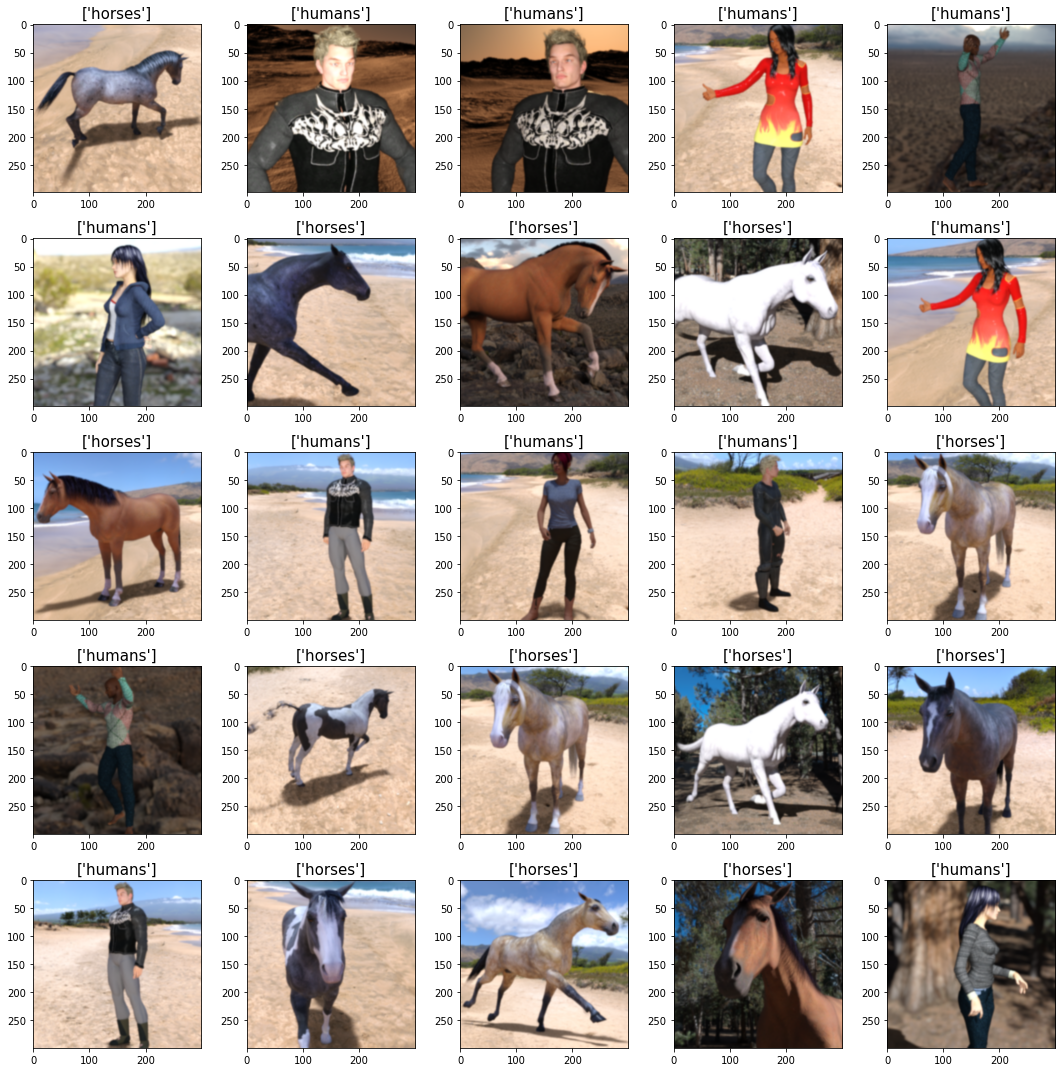

In [ ]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(5):
        num=np.random.randint(0,len(train_labels))
        ax[i,j].imshow(train_images[num])
        ax[i,j].set_title([train_labels[num]], size =15)
plt.tight_layout()

In [ ]:
train_dir = '../input/horses-or-humans-dataset/horse-or-human/train/'
val_dir = '../input/horses-or-humans-dataset/horse-or-human/validation/'

In [ ]:
train_horses = '/content/drive/MyDrive/horse-or-human/train/horses'
train_humans = '/content/drive/MyDrive/horse-or-human/train/humans'

In [ ]:
val_horses = '../input/horses-or-humans-dataset/horse-or-human/validation/horses/'
val_humans = '../input/horses-or-humans-dataset/horse-or-human/validation/humans/'

In [ ]:
print('Total number of training horse images: ',len(os.listdir(train_horses)))
print('Total number of training human images: ',len(os.listdir(train_humans)))
print('Total number of training images: ',len(os.listdir(train_humans)) + len(os.listdir(train_horses)))
print('\n')
print('Total number of validation horse images: ',len(os.listdir(val_horses)))
print('Total number of validation human images: ',len(os.listdir(val_humans)))
print('Total number of validation images: ',len(os.listdir(val_humans)) + len(os.listdir(val_horses)))

Total number of training horse images:  500
Total number of training human images:  527
Total number of training images:  1027




FileNotFoundError: ignored

###Preparing Data

In [ ]:
train_generator = ImageDataGenerator(1./255, 
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)

In [ ]:
val_generator = ImageDataGenerator(1./255)

In [ ]:
train_batch = train_generator.flow_from_directory(train_dir,
                                                target_size = (150,150),
                                                batch_size = 20,
                                                class_mode = 'binary')

In [ ]:
val_batch = val_generator.flow_from_directory(val_dir,
                                                 target_size = (150,150),
                                                 batch_size = 20,
                                                 class_mode = 'binary')

In [ ]:
learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

In [ ]:
xception_base = Xception(include_top = False,
                         weights="imagenet",
                         input_shape=(150,150,3)
                        )
xception_base.trainable = True #Make base trainable.

vgg16_base = VGG16(include_top = False,
                   weights="imagenet",
                   input_shape=(150,150,3)
                  )
vgg16_base.trainable = False

###Model - 1 : Transfer Learning - Xception

In [ ]:
model = keras.Sequential([
    xception_base,
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

#Compiling model
model.compile(optimizer = RMSprop(lr = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

#Fit model
history = model.fit_generator(train_batch_gen,
                    epochs = 30,
                    steps_per_epoch = 50,
                    validation_data = val_batch_gen,
                    validation_steps = 12,
                    callbacks = [learning_rate_reduction]
         
)

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
# plt.yticks(np.linspace(0.96,0.995))

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='lower left')


plt.tight_layout()
plt.show()

###Model - 2 : Transfer Learning VGG-16

In [ ]:
model2 = keras.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

#Compiling model
model2.compile(optimizer = RMSprop(lr = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['binary_accuracy'])

#Fit model
history2 = model.fit_generator(train_batch_gen,
                    epochs = 30,
                    steps_per_epoch = 50,
                    validation_data = val_batch_gen,
                    validation_steps = 12,
                    callbacks = [learning_rate_reduction]
         
)

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(2, 1, 1)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
# plt.yticks(np.linspace(0.96,0.995))

plt.subplot(2, 1, 2)
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='lower left')


plt.tight_layout()
plt.show()

###Model - 3: Transfer Learning - Inception

In [ ]:
def preprocess_labels(labels):
    le = LabelEncoder()
    
    labels = le.fit_transform(labels)
    labels = to_categorical(labels)
    labels = np.array(labels)
    labels = [int(i[0])for i in labels]
    return labels

In [ ]:
train_labels_lst = preprocess_labels(train_labels)
valid_labels_lst = preprocess_labels(valid_labels)

In [ ]:
train_images, test_images, train_labels_lst, test_labels_lst = train_test_split(train_images, train_labels_lst, 
                                                                        test_size=0.25, random_state=20)

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0
valid_images = valid_images / 255.0

In [ ]:
train_images.shape, test_images.shape, valid_images.shape

((770, 300, 300, 3), (257, 300, 300, 3), (256, 300, 300, 3))

In [ ]:
batch_size = 32
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                                                           rotation_range=25,
                                                           zoom_range=0.1,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           shear_range=0.2,
                                                           horizontal_flip=True)

test_datagen = keras.preprocessing.image.ImageDataGenerator()
val_datagen = keras.preprocessing.image.ImageDataGenerator()

AttributeError: ignored

###Model-1 Transfer Learning - VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (300, 300, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)
x = layers.BatchNormalization()(x)

x = layers.Dense(32, activation='relu')(x)

x = layers.Dense(1, activation='sigmoid')(x)

vgg_model = tf.keras.models.Model(base_model.input, x)

In [ ]:
vgg_model.summary()

####Train model

In [ ]:
vgg_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [ ]:
t1 = time.time()
history = vgg_model.fit_generator(train_gen, epochs=10, validation_data=test_gen)
t2 = time.time()

In [ ]:
print('Time to train model:',round((t2-t1)/60, 2), 'minuts')

In [ ]:
# plot model loss
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

####Test Model

In [ ]:
# Train data evaluation
train_score = vgg_model.evaluate_generator(train_gen)

# Test data evaluation
test_score = vgg_model.evaluate_generator(test_gen)

# Validation data evaluation
valid_score = vgg_model.evaluate_generator(valid_gen)

In [ ]:
print("Train_Accuracy = ", train_score[1])
print("Test_Accuracy = ", test_score[1])
print("Validation_Accuracy = ", valid_score[1])

####Prediction

In [ ]:
# prediction 
pred = vgg_model.predict_generator(valid_gen)
predicted_vals = [round(i[0]) for i in pred]

In [ ]:
# Confusion Matrix

cm = confusion_matrix(valid_labels_lst, predicted_vals)
cm

###Model-2 Transfer Learning - B7

In [ ]:
!pip install -U efficientnet

In [ ]:
import efficientnet.keras as efn

base_model = efn.EfficientNetB7(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1, activation='sigmoid')(x)

efficientnet_b7 = tf.keras.models.Model(base_model.input, x)

In [ ]:
efficientnet_b7.summary()

In [ ]:
print('Time to train model:',round((t2-t1)/60, 2), 'minuts')

In [ ]:
# plot model loss
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# Plot model accuracy 
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

####Test model

In [ ]:
# Train data evaluation
train_score = efficientnet_b7.evaluate_generator(train_gen)

# Test data evaluation
test_score = efficientnet_b7.evaluate_generator(test_gen)

# Validation data evaluation
valid_score = efficientnet_b7.evaluate_generator(valid_gen)

In [ ]:
print("Train_Accuracy = ", train_score[1])
print("Test_Accuracy = ", test_score[1])
print("Validation_Accuracy = ", valid_score[1])

####Prediction

In [ ]:
# prediction 
pred = efficientnet_b7.predict_generator(valid_gen)
predicted_vals = [round(i[0]) for i in pred]

In [ ]:
# Confusion Matrix

cm = confusion_matrix(valid_labels_lst, predicted_vals)
cm

###Model-3 Transfer Learning - Inception

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)
x = layers.BatchNormalization()(x)

x = layers.Dense(32, activation='relu')(x)

x = layers.Dense(1, activation='sigmoid')(x)

inception_model = tf.keras.models.Model(base_model.input, x)

In [ ]:
inception_model.summary()

####Train Model

In [ ]:
# compile model

inception_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [ ]:
t1 = time.time()
history = inception_model.fit_generator(train_gen, epochs=10, validation_data=test_gen)
t2 = time.time()

In [ ]:
print('Time to train model:',round((t2-t1)/60, 2), 'minuts')

In [ ]:
# plot model loss
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# Plot model accuracy 
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

####Test Model

In [ ]:
# Train data evaluation
train_score = inception_model.evaluate_generator(train_gen)

# Test data evaluation
test_score = inception_model.evaluate_generator(test_gen)

# Validation data evaluation
valid_score = inception_model.evaluate_generator(valid_gen)

In [ ]:
print("Train_Accuracy = ", train_score[1])
print("Test_Accuracy = ", test_score[1])
print("Validation_Accuracy = ", valid_score[1])

####Prediction

In [ ]:
# prediction 
pred = inception_model.predict_generator(valid_gen)
predicted_vals = [round(i[0]) for i in pred]

In [ ]:
cm = confusion_matrix(valid_labels_lst, predicted_vals)
cm



---

